In [17]:
!pip install pyDOE

In [17]:
from google.colab import drive
drive.mount('/content/drive')

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import *
from scipy.stats.distributions import lognorm
#import stochpy
import time
import sys
import os
from datetime import datetime
# import kkfunctions as kk
import matplotlib as mpl
import scipy as sp
import seaborn as sns
import pandas as pd
from collections.abc import Mapping

In [55]:
mpl.rcParams.update({'font.size':15})

In [56]:
dt = 0.1
variability = 0.5
density = 'high'

parameters = {'a1': 5500,
              'b2': 1.3,
              'b3': 1.3,
              'd1': 0.26,
              'd2': 0.26,
              'd3': 3.9,
              'h1': 2,
              'K1': 50,
              'S3': 100}

fixed_pars = ['a1', 'h1']
pars_to_use = ['a1', 'b2', 'b3', 'd1', 'd2', 'd3', 'h1', 'K1', 'S3']
param_names = {'a1':'$\\alpha_1$',
               'b2':'$\\beta_2$', 'b3':'$\\beta_3$',
               'd1':'$d_1$', 'd2':'$d_2$', 'd3':'$d_3$',
               'h1':'$h_1$',
               'K1':'$K_1$','K3':'$S_3$'}

In [58]:
def assign_parameters(nReps, variability, parameters, pars_to_use=[], fixed_pars=[]):

    if not pars_to_use:
        pars_to_use = list(parameters.keys())

    locs = np.asarray([parameters[x] for x in pars_to_use])
    scales = variability*locs
    nPars = len(pars_to_use)

    # determine parameter values based on variability
    locs = locs - scales
    design = lhs(nPars, samples=nReps)
    for i, param in enumerate(pars_to_use):
        if variability==0: # no variability in parameter selection, uses mean values defined
            design[:,i] = locs[i]
        elif param in fixed_pars: # manual assignment for certain parameters
            design[:,i] = parameters[param]
        else: # chooses parameter value from lognorm distribution
            design[:,i] = lognorm(s=0.1, loc=locs[i], scale=scales[i]).ppf(design[:,i])
    design[design<=0] = 0 ### just in case a negative comes up, maybe just use poisson instead?

    return design

To use the Next Reaction algorithm, we split the differential equations into separate production and degradation reactions. Each reaction is later used as the propensity for selecting the next reaction. <br>

$
\begin{align}
    &Z \rightarrow Z + X \\
    &R1 = \frac{\alpha_x}{1+\left(\frac{Z}{K_x}\right)^{h_1}} \\\\
    &X \rightarrow \varnothing \\
    &R2 = \delta_x X \\\\
    &X \rightarrow X + Y \\
    &R3 = \beta_y X \\\\
    &Y \rightarrow \varnothing \\
    &R4 = \delta_y Y \\\\
    &Y \rightarrow Y + Z \\
    &R5 = \beta_z Y \\\\
    &Z \rightarrow \varnothing \\
    &R6 = \frac{\delta_z Z}{1+\frac{Z}{S_3}} \\\\
\end{align}
$

In [59]:
def reactions(xyz):
    X,Y,Z = xyz
    r1 = a1/(1+(Z/k1)**h1)
    r2 = d1*X
    r3 = b2*X
    r4 = d2*Y
    r5 = b3*Y
    r6 = d3*Z/(1+(Z/s3))
    rs = np.array([r1,r2,r3,r4,r5,r6])
    return rs

In [60]:
columns = ['R1','R2','R3','R4','R5','R6']
index = ['X','Y','Z']
xrow =  [1, -1, 0,  0, 0,  0]
yrow =  [0,  0, 1, -1, 0,  0]
zrow =  [0,  0, 0,  0, 1, -1]
stoicArr = np.array([xrow,yrow,zrow])
stoicMat = pd.DataFrame(stoicArr, index=index, columns=columns)
print('Stoichiometry Matrix')
print('')
print(stoicMat)

Stoichiometry Matrix

   R1  R2  R3  R4  R5  R6
X   1  -1   0   0   0   0
Y   0   0   1  -1   0   0
Z   0   0   0   0   1  -1


In [62]:
save_results = True
tsim = 24*20 # units are hours, run for 20 days
dt = 0.1
tvec = np.arange(0,tsim+dt,dt)
a_vec = [5500, 100000]
xyz = np.array([100,100,400]) # initial conditions

nReps = 100
# parent = 'C:/Users/keith/google_drive_school/Python/Mechanobiology/'

for i, a1 in enumerate(a_vec):
    parameters['a1'] = a1

    now = datetime.now().strftime('%H:%M')
    print('a1 = {}'.format(a1))
    print(now)

    dataframe = np.zeros((nReps, len(tvec), 3))
    design = assign_parameters(nReps, variability, parameters, pars_to_use=pars_to_use, fixed_pars=fixed_pars)

    for rep in range(nReps):

        print('\rrep: {}/{}'.format(rep+1,nReps), end='')
        a1, b2, b3, d1, d2, d3, h1, k1, s3 = design[rep]

        t = 0
        xyzVec = np.zeros((tvec.size,xyz.size))
        ivec = 0

        while t<tsim:
            while t > tvec[ivec]:
                xyzVec[ivec,:] = xyz
                ivec = ivec + 1

            propensity = reactions(xyz)
            probability = propensity / np.sum(propensity)
            probCumSum = np.cumsum(probability)
            rand1 = np.random.uniform(0,1) # select random number between 0 and 1
            tau = -np.log(rand1)/np.sum(propensity) # time to the next reaction
            rand2 = np.random.uniform(0,1) # select random number between 0 and 1
            nReaction = np.where(probCumSum>rand2)[0][0]
            xyz = xyz + stoicArr[:,nReaction]
            t = t + tau

        xyzVec[-1,:] = xyz
        dataframe[rep] = xyzVec

    # plot the last repetition
    xvec,yvec,zvec = xyzVec.T
    plt.plot(tvec,xvec)
    plt.plot(tvec,yvec)
    plt.plot(tvec,zvec)
    plt.show()

    # save the repetitions for a1
    # file_tvec = 'results/a_{}_tvec.npy'.format(int(a1))
    # file_sim = 'results/a_{}_simulation.npy'.format(int(a1))
    # file_par = 'results/a_{}_parameters.npy'.format(int(a1))
    file_tvec = 'a_highlow_{}_tvec.npy'.format(int(a1))
    file_sim = 'a_highlow_{}_simulation.npy'.format(int(a1))
    file_par = 'a_highlow_{}_parameters.npy'.format(int(a1))
    if save_results:
        np.save(file_tvec, tvec)
        np.save(file_sim, dataframe)
        np.save(file_par, np.array(design))

a1 = 5500
16:43
rep: 7/10

KeyboardInterrupt: ignored

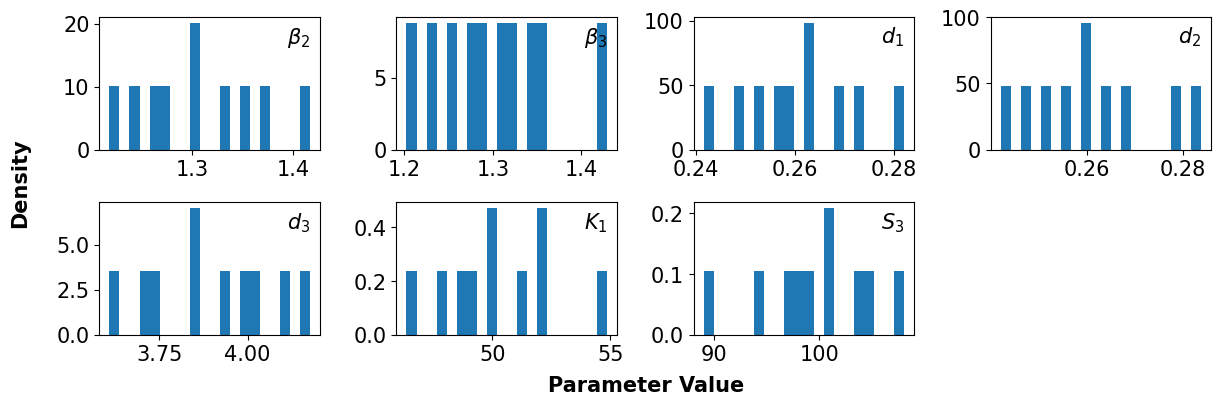

In [35]:
# plot parameter distributions
save_figure = True
a1 = 100000
file_sim = 'a_highlow_{}_simulation.npy'.format(int(a1))
file_par = 'a_highlow_{}_parameters.npy'.format(int(a1))
file_png = 'a_highlow_{}_parameter_distributions.png'.format(int(a1))
file_svg = 'a_highlow_{}_parameter_distributions.svg'.format(int(a1))
file_pdf = 'a_highlow_{}_parameter_distributions.pdf'.format(int(a1))
file_tvec = 'a_highlow_{}_tvec.npy'.format(int(a1))
pars_to_show = ['b2', 'b3', 'd1', 'd2', 'd3', 'K1', 'K3']
label_names = [param_names[x] for x in pars_to_show]
remove = [0,6] # don't show a1 and h1 in the distributions because they are fixed

design = np.load(file_par)
design = np.delete(design,remove,axis=1) # remove a1 and h1 columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,4))
for i, params in enumerate(design.T):
    ax = axes.flat[i]
    ax.hist(params, bins=20, density=True)
    ax.text(x=0.85, y=0.8, s=label_names[i], transform=ax.transAxes)
# axes[-1,-1].set_xticks([])
# axes[-1,-1].set_yticks([])
axes[-1,-1].axis('off')

fig.text(x=0.51, y=-0.01, s='Parameter Value', transform=fig.transFigure, ha='center', fontweight='bold')
fig.text(x=-0.02, y=0.51, s='Density', transform=fig.transFigure, va='center', rotation=90, fontweight='bold')
plt.tight_layout()
if save_figure:
    plt.savefig(file_png, format='png', dpi=300, bbox_inches='tight')
    plt.savefig(file_svg, format='svg', dpi=300, bbox_inches='tight')
    plt.savefig(file_pdf, format='pdf', dpi=300, bbox_inches='tight')
plt.show()

a1 = 1000
16:45
rep: 1/1

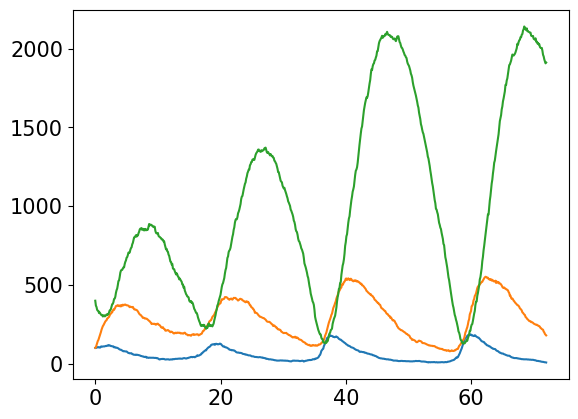

a1 = 2000
16:45
rep: 1/1

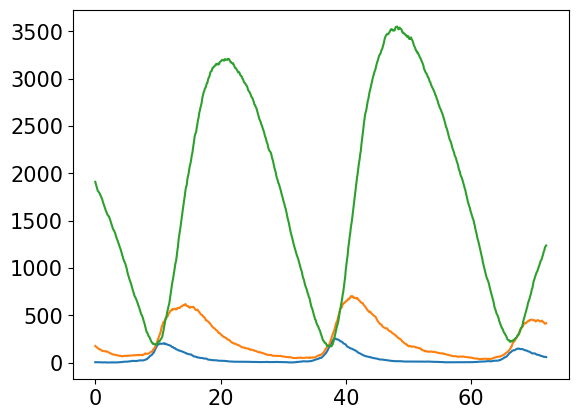

a1 = 3000
16:45
rep: 1/1

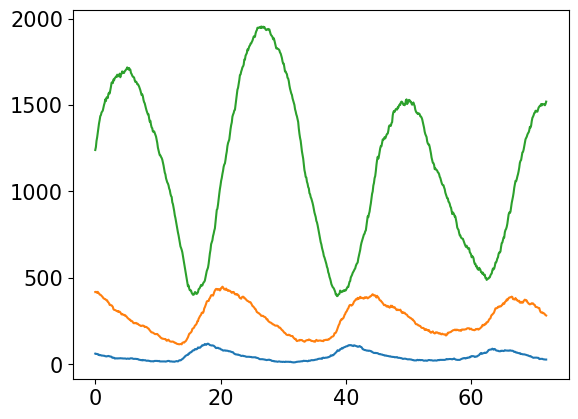

a1 = 4000
16:45
rep: 1/1

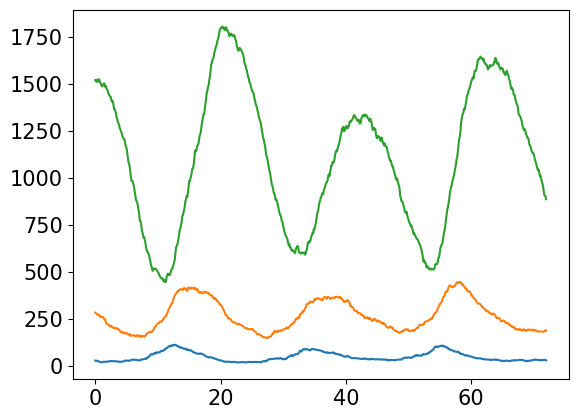

a1 = 5000
16:45
rep: 1/1

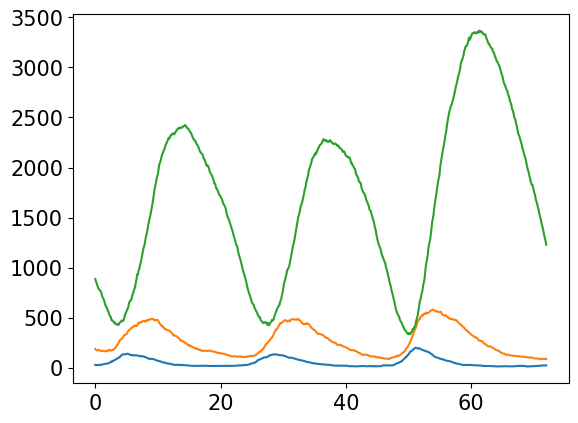

a1 = 6000
16:45
rep: 1/1

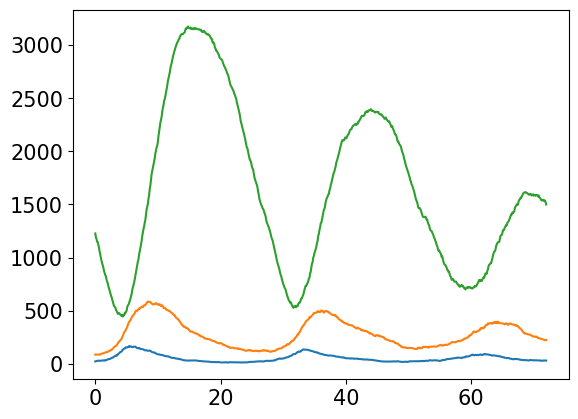

a1 = 7000
16:45
rep: 1/1

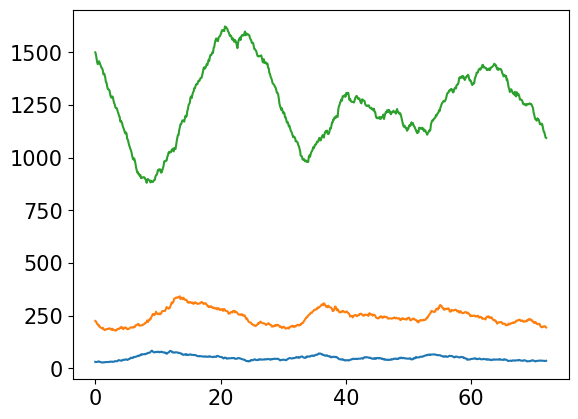

a1 = 8000
16:45
rep: 1/1

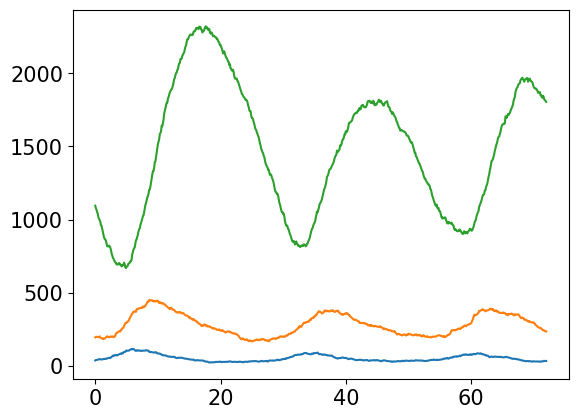

a1 = 9000
16:45
rep: 1/1

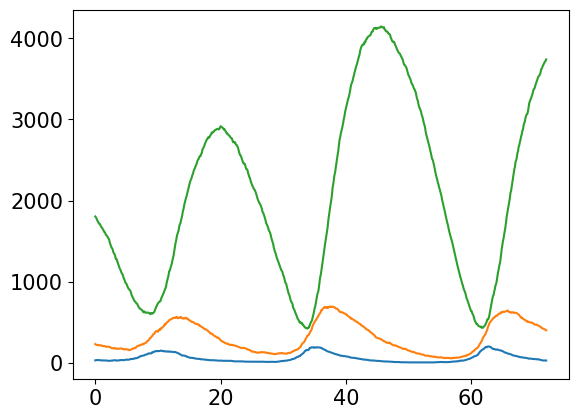

a1 = 10000
16:46
rep: 1/1

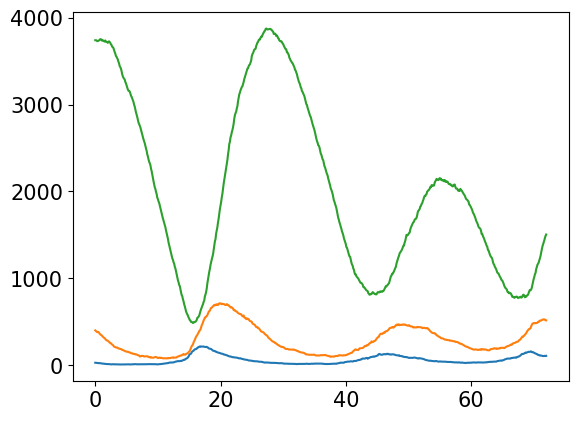

In [64]:
save_results = True
tsim = 24*3 # units are hours, run for 20 days
dt = 0.1
tvec = np.arange(0,tsim+dt,dt)
a_vec = np.arange(0,100001,50)
a_vec[0] = 1
xyz = np.array([100,100,400]) # initial conditions

nReps = 1

for i, a1 in enumerate(a_vec):
    parameters['a1'] = a1

    now = datetime.now().strftime('%H:%M')
    print('a1 = {}'.format(a1))
    print(now)

    dataframe = np.zeros((nReps, len(tvec), 3))
    design = assign_parameters(nReps, variability, parameters, pars_to_use=pars_to_use, fixed_pars=fixed_pars)

    for rep in range(nReps):

        print('\rrep: {}/{}'.format(rep+1,nReps), end='')
        a1, b2, b3, d1, d2, d3, h1, k1, s3 = design[rep]

        t = 0
        xyzVec = np.zeros((tvec.size,xyz.size))
        ivec = 0

        while t<tsim:
            while t > tvec[ivec]:
                xyzVec[ivec,:] = xyz
                ivec = ivec + 1

            propensity = reactions(xyz)
            probability = propensity / np.sum(propensity)
            probCumSum = np.cumsum(probability)
            rand1 = np.random.uniform(0,1) # select random number between 0 and 1
            tau = -np.log(rand1)/np.sum(propensity) # time to the next reaction
            rand2 = np.random.uniform(0,1) # select random number between 0 and 1
            nReaction = np.where(probCumSum>rand2)[0][0]
            xyz = xyz + stoicArr[:,nReaction]
            t = t + tau

        xyzVec[-1,:] = xyz
        dataframe[rep] = xyzVec

    # plot the last repetition
    xvec,yvec,zvec = xyzVec.T
    plt.plot(tvec,xvec)
    plt.plot(tvec,yvec)
    plt.plot(tvec,zvec)
    plt.show()

    # save the repetitions for a1
    # file_tvec = 'results/a_{}_tvec.npy'.format(int(a1))
    # file_sim = 'results/a_{}_simulation.npy'.format(int(a1))
    # file_par = 'results/a_{}_parameters.npy'.format(int(a1))
    file_tvec = 'a_increase_{}_tvec.npy'.format(int(a1))
    file_sim = 'a_increase_{}_simulation.npy'.format(int(a1))
    file_par = 'a_increase_{}_parameters.npy'.format(int(a1))
    if save_results:
        np.save(file_tvec, tvec)
        np.save(file_sim, dataframe)
        np.save(file_par, np.array(design))

### Reverb-a and gradually increasing YAP ($\alpha_1$)

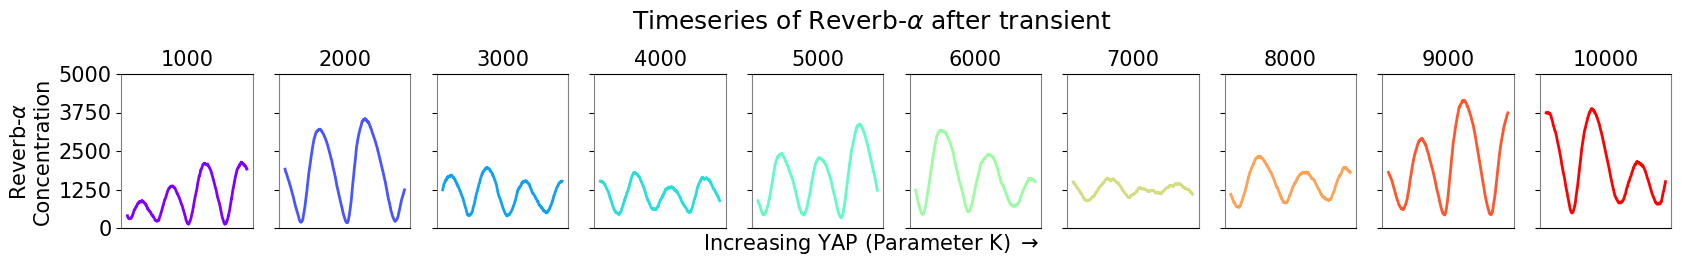

In [65]:
# each graph is separate
mpl.rcParams.update({'font.size':15})

save_figure = False
plot_figure = True
a_vec = np.arange(0,100001,50)
a_vec[0] = 1
# a_show = a_vec[::2]
a_show = a_vec

n_reps = 1
species = 2 # 0: Bmal, 1: Reverb-a (mRNA), 2: Reverb-a (prot)

tvec = np.load('a_increase_{}_tvec.npy'.format(a_vec[0]))
tStart = 24*0 # starting time in hours
iStart = np.where(tvec>=tStart)[0][0]
tshow = tvec[iStart:]

simulations = {}
parameters = {}

a_real = np.zeros(len(a_show)*n_reps) # 1-d array of all k values
tSeries = np.zeros((len(a_show)*n_reps,len(tshow),3))
avg_ra = np.zeros(len(a_show)*n_reps) # average reverb-a concentration after transient

for i, a1 in enumerate(a_show):

    baseFile = 'results/a_{}_'.format(int(a1))
    file_sim = 'a_increase_{}_simulation.npy'.format(int(a1))
    file_par = 'a_increase_{}_parameters.npy'.format(int(a1))
    simulations[a1] = np.load(file_sim)
    parameters[a1] = np.load(file_par)
    ind = n_reps*i # starting index for group of alpha1's
    a_real[ind:ind+n_reps] = parameters[a1][:n_reps,0]
    trajectories = simulations[a1][:n_reps,iStart:,species]
    avg_ra[ind:ind+n_reps] = np.mean(trajectories, axis=1)
    tSeries[ind:ind+n_reps] = simulations[a1][:n_reps,iStart:]

iSort = np.argsort(a_real)
a_true = a_real[iSort]
trueSeries = tSeries[iSort]
a_show = a_true
showSeries = trueSeries[:,:,species]

if plot_figure:
    fig, axes = plt.subplots(nrows=1, ncols=len(a_show), figsize=(20,2), sharex=True, sharey=True)
    for i, (a1, traj) in enumerate(zip(a_show,showSeries)):

        cmap = mpl.colormaps.get_cmap('rainbow') # one color per k-value
        pColor = i/(len(a_show)-1) # percent of colormap
        ax = axes.flat[i]
        ax.plot(tshow, traj, color=cmap(pColor), linewidth=2) # one representative timeseries from each K
        if (a1 % 25) == 0:
            ax.set_title(int(a1), rotation=0, fontsize=15)
            ax.set_ylim([0,5000])
        ax.set_yticks(np.linspace(0,5000,5))
        ax.set_xticks([], minor=False)
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')

    axes[0].set_ylabel('Reverb-$\\alpha$\nConcentration')
    fig.text(x=0.5, y=0, s=r'Increasing YAP (Parameter K) $\rightarrow$', ha='center')
    # fig.text(x=0.805, y=0.72, s='Variability: {}'.format(noises[n_samp]), ha='left', transform=fig.transFigure, bbox={'edgecolor':'black','facecolor':'white'})
    fig.suptitle(r'Timeseries of Reverb-$\alpha$ after transient', y=1.2)

    file_plot = 'z_timeseries_increasing_a1.svg'
    plt.subplots_adjust(wspace=0.2)
    if save_figure:
        plt.savefig(file_plot, format='svg', dpi=300, bbox_inches="tight")
    plt.show()